# Thesis figures part 2

This figure argues the different behaviors between $n=1$ and $n=3$ (generally ultrasensitive case)

In [1]:
include("simu_utils.jl")
pyplot()

Plots.PyPlotBackend()

In [6]:
function traj(sol, stress_t, max_t, dt; 
        plot_t = 2e3, c = :blue, max_y = 70., hide_x = false)
    # plot start and end
    from = Int64(round(stress_t / dt))
    to = from + Int64(round(plot_t / dt))
    
    # interpret results
    t, σ, ~ = interpret_sol(sol)
    
    # plot
    plot(t[from:to] .- stress_t, σ[from:to], color = c, legend = :none)
    plot!(size = (300, 200))
    xlims!(t[from] - stress_t, t[to] - stress_t)
    xlabel!("Time")
    ylabel!("Number of molecules")
    if hide_x
        plot!(xticks = false, xlabel = "")
    end
    ylims!(0., max_y)
    yticks!(0.:(max_y <= 50. ? 10. : 20.):max_y)
end

traj (generic function with 1 method)

### Vector field

In [4]:
function simple_vf(sol, stress_t, dt, β; hide_x = false)
    # beta is required for finding fps
    
    # get the vector field
    # each row is a certain σ, each col is an A
    dσdt, dAdt, ~, passage = vector_field(sol, stress_t, dt)
    
    # filter sparse grid points
    thres = 2e-4
    for i = 1:size(dσdt, 1)
        for j = 1:size(dσdt, 2)
            if passage[i, j] < thres * maximum(passage)
                dσdt[i, j] = dAdt[i, j] = 0.0
            end
        end
    end
    
    # shrink boundries
    magnitude = sqrt.(dσdt.^2 .+ dAdt.^2)
    # select the max non-zero index
    σ_max = maximum((1:size(dσdt, 1))[(sum(magnitude, dims = 2) .> 1e-16)[:]])
    A_max = maximum((1:size(dAdt, 2))[(sum(magnitude, dims = 1) .> 1e-16)[:]])
    dσdt = dσdt[1:σ_max, 1:A_max]
    dAdt = dAdt[1:σ_max, 1:A_max]
    
    # decide the interval
    smaller_dim = min(size(dσdt)...)
    max_density = 10
    int = max(1, Int64(ceil(smaller_dim / max_density)))
    
    # sparsify
    σ_selected = 1:int:size(dσdt, 1)
    A_selected = 1:int:size(dσdt, 2)
    dσdt = dσdt[σ_selected, A_selected]
    dAdt = dAdt[σ_selected, A_selected]
    
    # get the grids
    σ_grid = σ_selected .* ones(size(dσdt)...) .- 1    # each row is 1,2,3...
    A_grid = A_selected' .* ones(size(dσdt)...) .- 1    # each col is 1,2,3...
    
    # normalize
    scale = 0.7
    new_mag = sqrt.(dσdt.^2 .+ dAdt.^2)
    for i = 1:size(dσdt, 1)
        for j = 1:size(dσdt, 2)
            if new_mag[i, j] > 1e-16    # to avoid divide by 0
                dσdt[i, j] = dσdt[i, j] / new_mag[i, j] * (scale * int)
                dAdt[i, j] = dAdt[i, j] / new_mag[i, j] * (scale * int)
            end
        end
    end
    
    # also show fixed points
    fp, ~, ~ = find_fp(sol, stress_t, dt, β, thres_v = 1.5e-3)
    
    # plot
    # transpose: map σ to y axis
    quiver(σ_grid[:], A_grid[:], quiver = (dσdt[:], dAdt[:]),
        aspect_ratio = :equal)
    plot!(framestyle = :box, grid = :none)
    plot!(ylabel = "A", xlabel = "σ")
        if hide_x
        plot!(xticks = false, xlabel = "")
    end
    # plot fps (green) (fp already starts from 0)
    scatter!(fp[:, 1], fp[:, 2], markersize = 8, color = :darkred, label = :none,
        markerstrokewidth = 0)
    # resize
    plot!(size = (200/A_max*σ_max, 200))
end
    

simple_vf (generic function with 1 method)

## Oscillation

$n = 2$

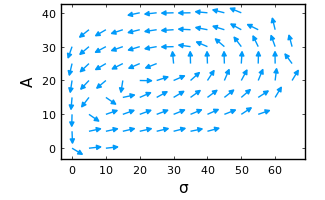

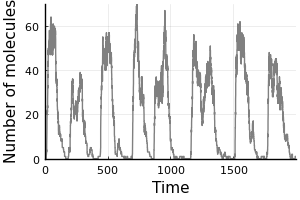

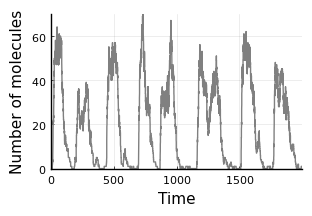

In [7]:
# reaction definitions
network = new_reaction_system()

# simulation settings
stress_t = 1e3
max_t = 5e6    # vf requires longer simulation time
dt = 0.2

# model parameters
KS = 0.2
rK = 1.0
n = 3.0

# simulation
sol = simu_all(network, _β = 50.0, _n = n, _rτ = 5.0, _τ₁ = 10.0,
    _KS = KS, _rK = rK,
    stress_t = stress_t, max_t = max_t, saveat = dt, quiet = true)

# plot
p1 = simple_vf(sol, stress_t, dt, 50.)
p2 = traj(sol, stress_t, max_t, dt, c = :gray)
display(p1)
display(p2)


## Irregular fluctuation

$n = 1$

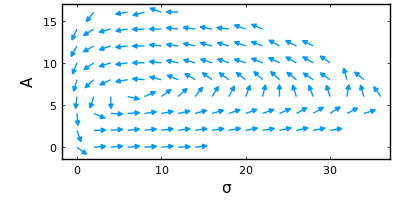

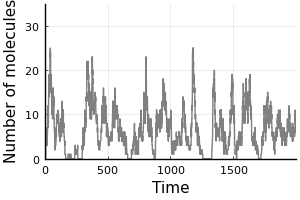

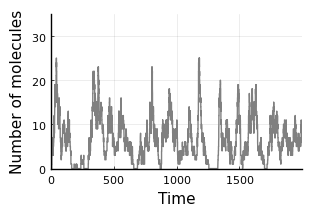

In [9]:
# reaction definitions
network = new_reaction_system()

# simulation settings
stress_t = 1e3
max_t = 5e6    # vf requires longer simulation time
dt = 0.2

# model parameters
KS = 1.0
rK = 0.15
n = 1.0

# simulation
sol = simu_all(network, _β = 50.0, _n = n, _rτ = 5.0, _τ₁ = 10.0,
    _KS = KS, _rK = rK,
    stress_t = stress_t, max_t = max_t, saveat = dt, quiet = true)

# plot
p1 = simple_vf(sol, stress_t, dt, 50.)
p2 = traj(sol, stress_t, max_t, dt, c = :gray, max_y = 35.)
display(p1)
display(p2)

## Stochastic switching

$n = 2$

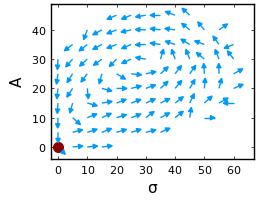

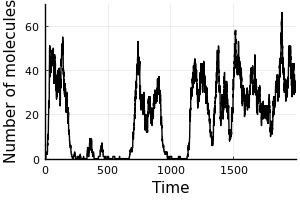

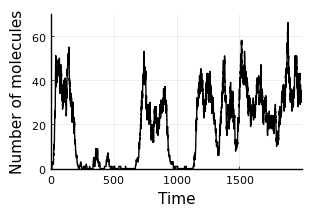

In [17]:
# reaction definitions
network = new_reaction_system()

# simulation settings
stress_t = 1e3
max_t = 5e6    # vf requires longer simulation time
dt = 0.2

# model parameters
KS = 9.0
rK = 2.0
n = 2.0

# simulation
sol = simu_all(network, _β = 50.0, _n = n, _rτ = 5.0, _τ₁ = 10.0,
    _KS = KS, _rK = rK,
    stress_t = stress_t, max_t = max_t, saveat = dt, quiet = true)

# plot
p1 = simple_vf(sol, stress_t, dt, 50.)
p2 = traj(sol, stress_t, max_t, dt, c = :black)
display(p1)
display(p2)

## Also "Stochastic switching"

$n = 1$

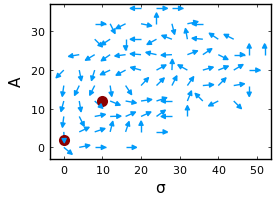

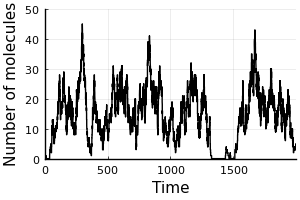

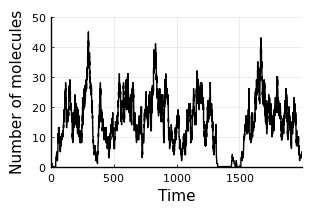

In [79]:
# reaction definitions
network = new_reaction_system()

# simulation settings
stress_t = 1e3
max_t = 1e5    # vf requires longer simulation time
dt = 0.2

# model parameters
KS = 30.0
rK = 12.0
n = 1.0

# simulation
sol = simu_all(network, _β = 50.0, _n = n, _rτ = 5.0, _τ₁ = 10.0,
    _KS = KS, _rK = rK,
    stress_t = stress_t, max_t = max_t, saveat = dt, quiet = true)

# plot
p1 = simple_vf(sol, stress_t, dt, 50.)
p2 = traj(sol, stress_t, max_t, dt, c = :black, max_y = 50.)
display(p1)
display(p2)


## Save figures

In [80]:
savefig(p2, "traj_sto_switching_n1.pdf")
# savefig(p1, "vf_sto_switching_n1.pdf")